# Liveness Detection Model

## Table of Content


>[Liveness Detection Model](#scrollTo=MQzBVTKTRDGf)

>>>[Task](#scrollTo=dVgm74SMSdM1)

>>>[Dataset](#scrollTo=dVgm74SMSdM1)

>>[Stage 1: Preprocessing the Dataset](#scrollTo=3XFBjLeUT8hN)

>>>[Importing dataset](#scrollTo=PlxpNIvFB7XZ)

>>>[Exploring the data](#scrollTo=juUanVArhueZ)

>>>[Visualizing the dataset](#scrollTo=fPtXruHFiVhZ)

>>[Stage 2: Building the Model](#scrollTo=wA5FP7nOjgrM)

>>>[Importing libraries](#scrollTo=m9b1nr5IlMwN)

>>>[Image augumantaion (processing the image)](#scrollTo=lnI9P1iPDLr5)

>>>[Model Selection](#scrollTo=QZRTd7FklQID)

>>>[Model Compilation](#scrollTo=-Aw-c1cTm12d)

>>>[Model Checkpoint](#scrollTo=xz241AmEnK4q)

>>>[Visualizing Accuracy and Loss](#scrollTo=5oh_aokuCOSJ)

>>>[Making Predictions](#scrollTo=CaIaMpstCeDJ)

>>>[Calculating the Accuracy](#scrollTo=6GefQTCoARrX)




### Task
Build a simple Liveness Detection Model.

Liveness models are intelligent models that seek to differentiate between a real image and a spoof image. A real image in this case is a true and live capture of the individual usually image of a person captured directly from a camera while a spoof image are the ones being captured off an existing image either an image existing on a phone or a printed picture of a picture.
The task is to build a model that will help detect this kind of different image.

### Dataset

The dataset used for training contains both the spoof and real images. Find the daset [here](https://drive.google.com/file/d/1mDsSE3T7fw21woAP4WNIDTdpL2NbXOGL/view?usp=sharing)

- Real images- 972 images
- Spoof images- 2,818 images

For the purpose of this project I divided the dataset into test and train datasets. 

For the train dataset
- real - 777
- spoof - 2,253

For the test dataset
- real - 195
- spoof - 565

## Stage 1: Preprocessing the Dataset

### Importing dataset

We will start with importing the dataset from google drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!cp -r "/content/gdrive/MyDrive/dsdataset/image_dataset.zip" "/content"

In [3]:
from zipfile import ZipFile

archive = ZipFile('/content/image_dataset.zip')
archive.extractall('/content')

Defining directory Paths

In [4]:
# setting up directories
dataset_path = '/content/image_dataset'

train_dataset_path = '/content/image_dataset/train'
test_dataset_path = '/content/image_dataset/test'

train_path='/content/image_dataset/train'
test_path = '/content/image_dataset/test'

### Exploring the data

In [6]:
# Importing libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Seperating the dataset into categories

categories = ['real','spoof']

# Exploring the train and test dataset directories

print("---------------------Exploring Training Datasets[TRAIN]----------------")
for category in categories:
  path = os.path.join(train_path,category)
  if category == 'real':
    r1 = len(os.listdir(path))
  else:
    s1 = len(os.listdir(path))
  print("There are {} images in {} directory".format(len(os.listdir(path)),category))
print("There are {} total images in training directory".format(r1+s1))

print("----------------------Exploring Testing Datasets[TEST]-----------------")
for category in categories:
  path = os.path.join(test_path,category)
  if category == 'real':
    r2 = len(os.listdir(path))
  else:
    s2 = len(os.listdir(path))
  print("There are {} images in {} directory".format(len(os.listdir(path)),category))
print("There are {} total images in testing directory".format(r2+s2))

---------------------Exploring Training Datasets[TRAIN]----------------
There are 777 images in real directory
There are 2253 images in spoof directory
There are 3030 total images in training directory
----------------------Exploring Testing Datasets[TEST]-----------------
There are 195 images in real directory
There are 565 images in spoof directory
There are 760 total images in testing directory


### Visualizing the dataset 

Here, we will check to see what the dataset looks like.

In [7]:
# Defining a function to get the data paths of a number 
# of samples for both the real and spoof images

def get_images(data_path,number_of_samples):
  image_path = []

  for category in categories:
    path = os.path.join(data_path,category)
    i = 1

    for img in os.listdir(path):
      if i > number_of_samples:
        break
      else:
        image_path.append(os.path.join(path,img))
        i += 1

  return image_path

In [8]:
# Defining a function to view the data gotten from the get_images path

def visualize_dataset(image_path,rows,cols):
  fig = plt.figure(figsize=(10,10))

  for i in range(1,rows * cols + 1):
    fig.add_subplot(rows,cols,i)
    img_array = cv2.imread(image_path[i-1])
    fig.subplots_adjust(hspace=1)
    plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
    plt.xlabel(image_path[i-1].split('/')[-2])

  plt.show()

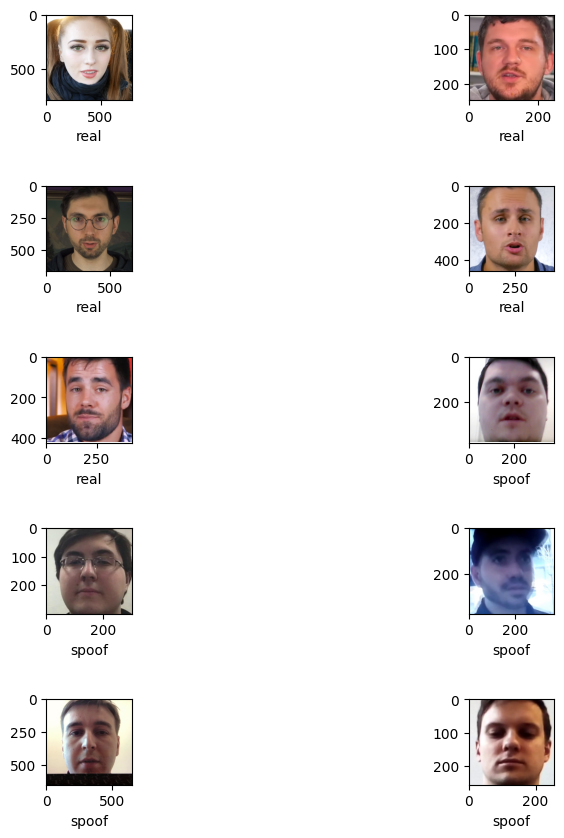

In [9]:
# Viewing the train images

train_image_path = get_images(data_path= train_path, number_of_samples=5)
visualize_dataset(image_path=train_image_path, rows=5, cols=2)


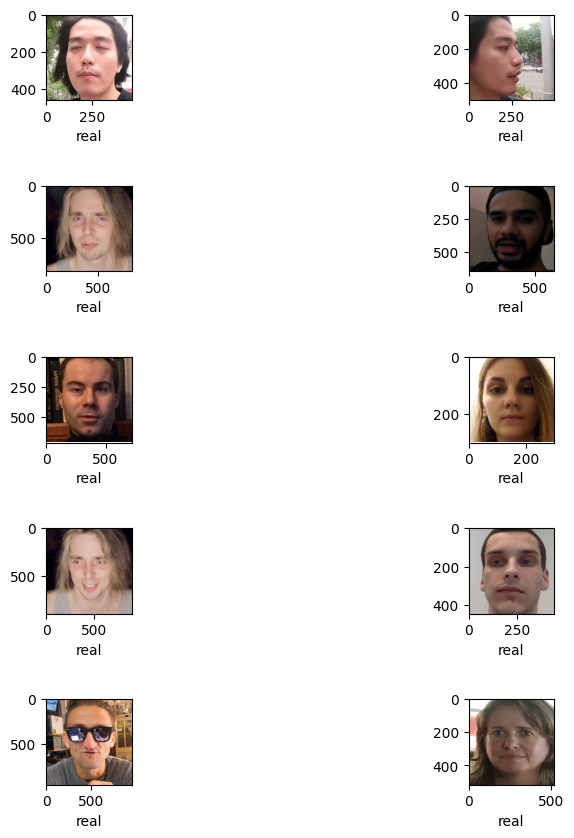

In [10]:
# Viewing the test images

test_image_path = get_images(data_path= test_path,number_of_samples=10)
visualize_dataset(image_path=test_image_path,rows=5,cols=2)

## Stage 2: Building the Model


For the model, we would be using the Keras framework.

In this stage we would go through several processes which includes

1.   Choosing the framework and importing the libraries needed (in this case Keras)
2.   Performing image augmentation on the dataset
3.   Model selection
4.   Compiling the model
5.   Model checkpoints





### Importing libraries

In [11]:
# Importing necessary Keras libraries

from keras.layers import Dense,Dropout,Input,Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import model_from_json
import json

### Image augumantaion (processing the image)

In [12]:
# Performimg Image augmentation to increase the dataset

train_datagen = ImageDataGenerator(brightness_range=(0.8,1.2),
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest',
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(160,160),
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    batch_size=25,
                                                    shuffle=True)

Found 3030 images belonging to 2 classes.


In [14]:
valid_generator = valid_datagen.flow_from_directory(test_path,
                                                    target_size=(160,160),
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    batch_size=25)
     

Found 760 images belonging to 2 classes.


### Model Selection

The model selected for this project is MobileNet. MobileNet is a streamlined architecture that uses Depthwise Separable convolutions to construct lightweight deep convolutional neural networks and provides an efficient model for mobile and embedded vision applications


In [15]:
mobilenet = MobileNetV2(weights="imagenet",
                        include_top=False,
                        input_tensor=Input(shape=(160,160,3)))

9406464/9406464 [==============================] - 1s 0us/step


In [16]:
mobilenet.trainable = False

In [17]:
output = Flatten()(mobilenet.output)
output = Dropout(0.3)(output)
output = Dense(units = 8,activation='relu')(output)
prediction = Dense(1,activation='sigmoid')(output)

In [18]:
model = Model(inputs = mobilenet.input,outputs = prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']           

### Model Compilation

In [19]:
# Compiling the model
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(
    learning_rate=0.000001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
),
  metrics=['accuracy']
)

### Model Checkpoint

We create model checkpoints to

In [20]:
# Creating a directory to store model weights for model checkpoint
os.mkdir('/content/model_weights/')
     

In [21]:
# model checkpoint
model_checkpoint = ModelCheckpoint('./model_weights/liveness_model_{epoch:02d}-{val_accuracy:.6f}.h5',
                                   monitor='val_loss', 
                                   mode='min', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True)
     


In [22]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 25,
    validation_data = valid_generator, 
    validation_steps = valid_generator.samples // 25,
    epochs = 100,
    callbacks=[model_checkpoint])

<ipython-input-22-61fac8fe248f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
121/121 [==============================] - ETA: 0s - loss: 0.7551 - accuracy: 0.6509
Epoch 1: val_loss improved from inf to 0.63066, saving model to ./model_weights/liveness_model_01-0.644000.h5
121/121 [==============================] - 101s 739ms/step - loss: 0.7551 - accuracy: 0.6509 - val_loss: 0.6307 - val_accuracy: 0.6440
Epoch 2/100
121/121 [==============================] - ETA: 0s - loss: 0.7295 - accuracy: 0.6729
Epoch 2: val_loss improved from 0.63066 to 0.59919, saving model to ./model_weights/liveness_model_02-0.680000.h5
121/121 [==============================] - 72s 596ms/step - loss: 0.7295 - accuracy: 0.6729 - val_loss: 0.5992 - val_accuracy: 0.6800
Epoch 3/100
121/121 [==============================] - ETA: 0s - loss: 0.7069 - accuracy: 0.6785
Epoch 3: val_loss improved from 0.59919 to 0.58152, saving model to ./model_weights/liveness_model_03-0.686667.h5
121/121 [==============================] - 68s 562ms/step - loss: 0.7069 - accuracy: 0.6785 - val_loss

In [26]:
# serialize model to JSON file
model_json = model.to_json()
with open("liveness_model.json", "w") as json_file:
    json_file.write(model_json)

### Visualizing Accuracy and Loss

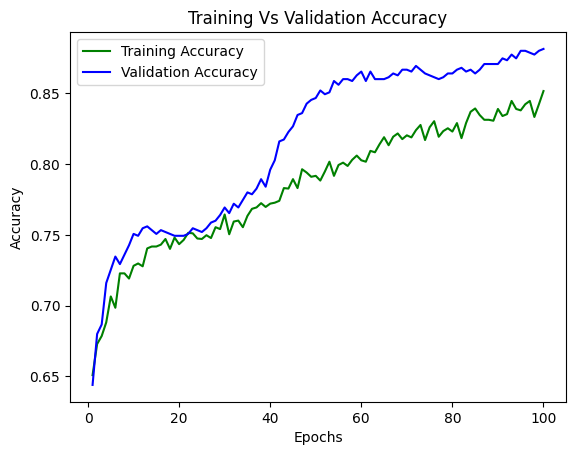

In [27]:
# Plotting the training accuracy and validation accuracy

import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1,101)
plt.plot(epochs,train_accuracy,'g',label='Training Accuracy')
plt.plot(epochs,validation_accuracy,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

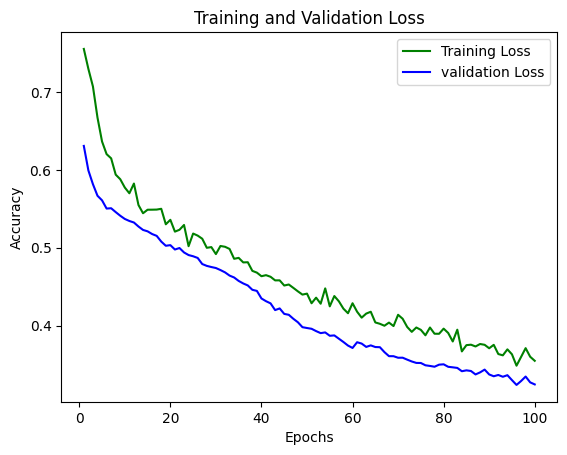

In [29]:
# Plotting the trainoing and validation losses

import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,101)
plt.plot(epochs,train_loss,'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
     

### Making Predictions

Here, we will test the model with the spoof and real test image dataset.

We would get the cross validation values and also calculate the cross validation accuracy.

In [30]:
 # Defining a function to run prediction of the dataset

from keras.utils import load_img, img_to_array
import numpy as np

def check_fakes(path,category_type):
  predictor = {}
  path= os.path.join(path,category_type)
  for img in os.listdir(path):
    try:
      img = load_img(os.path.join(path,img),target_size=(160,160))
      img = img_to_array(img)
      img = np.expand_dims(img,axis=0)
      img = img / 255.0
      prediction = model.predict(img)
      if prediction > 0.5:
        prediction_class = 1
      else:
        prediction_class = 0
      result = categories[prediction_class]
      if result not in predictor:
        predictor[result] = 1
      else:
        predictor[result] += 1
    except Exception as e:
      pass
  return predictor
     


In [33]:
# Testing predictions for the test spoof dataset

check_fakes(test_path,categories[1])

1/1 [==============================] - 0s 29ms/step


{'spoof': 514, 'real': 51}

This indicates that out of 565 spoof images, 514 were predicted correctly.

- True Negative (`TN`) = 514
- False Negative (`FN`) = 51

In [32]:
check_fakes(test_path,categories[0])

1/1 [==============================] - 0s 22ms/step


{'spoof': 39, 'real': 156}

This indicates that out of 195 real images, 156 were predicted correctly.

- True Positive (`TP`) = 156
- False Positive (`FP`) = 39

### Calculating the Accuracy

To calculate cross validation accuracy, the formula is:

Accuracy = (`TP` + `TN`) /(`TP` + `TN` + `FP` + `FN`)


In [38]:
# Calculating cross validation accuracy

accuracy = (156 + 514) / (156 + 514 + 39 + 51)

print("The cross-validation accuracy of the model is: {:.2f}".format(accuracy))

The cross-validation accuracy of the model is: 0.88
